In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from xgboost import plot_importance


public_data = pd.read_csv('extracted_public_data.csv')
public_data = public_data.dropna()
mapping = {
    "precision": {"single": 0, "double": 1},
    "backend": {"GPU": 0, "CPU": 1}
}
remapped_public_data = public_data.replace(mapping)
remapped_public_data['normalized_threshold'] = (1/8) * np.log2(remapped_public_data['threshold'])

features = pd.read_csv('qasm_features_scaled.csv')

match_col_test = remapped_public_data.columns[0]
match_col_features = features.columns[0]

inputs = pd.merge(
    remapped_public_data, 
    features, 
    left_on=match_col_test, 
    right_on=match_col_features, 
    how='left'
)
inputs = inputs.drop(columns=[match_col_features])



y = public_data['fidelity']
inputs = inputs.drop(columns=['circuit', "threshold", 'fidelity', 'expected_runtime_sec'])

inputs.to_csv('inputs.csv', index=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)


C:\Users\percy\AppData\Local\Temp\ipykernel_43576\3919160556.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  remapped_public_data = public_data.replace(mapping)


In [ ]:
X=inputs
Y=y


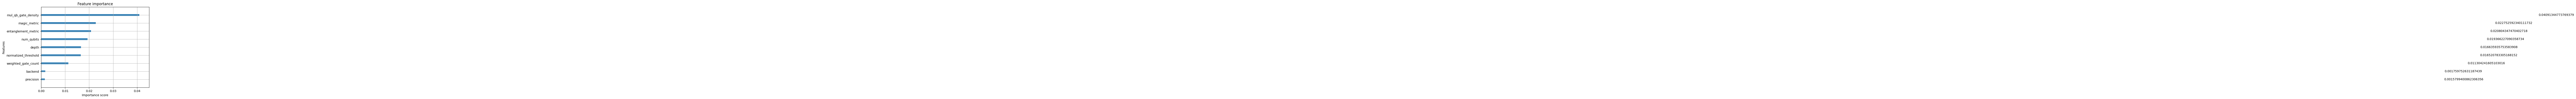

Fold 1 RMSE: 0.008020702856361044


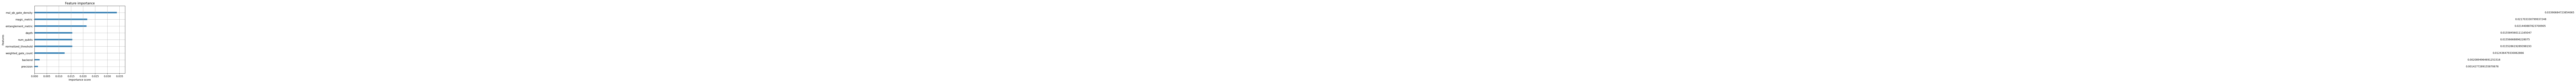

Fold 2 RMSE: 0.013005501044166883


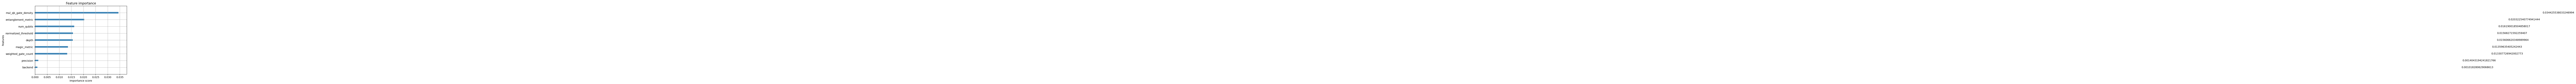

Fold 3 RMSE: 0.01657028026149712


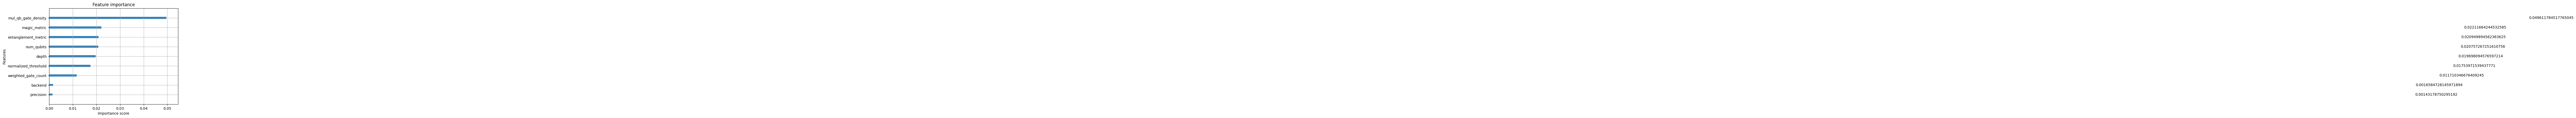

Fold 4 RMSE: 0.009627054617052


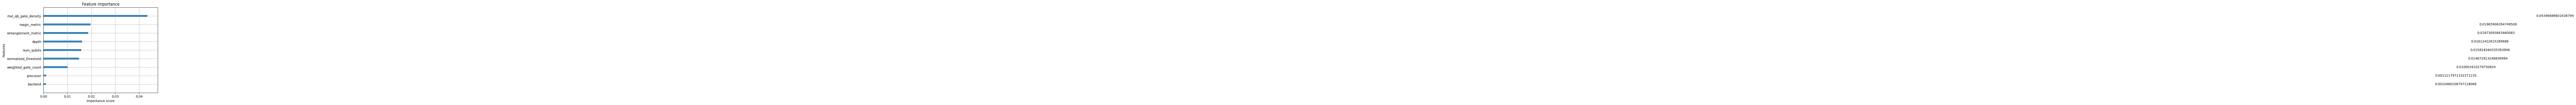

Fold 5 RMSE: 0.013640978624565429
CV RMSE: 0.012172903480728494


In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train = X.iloc[train_idx]
    X_val   = X.iloc[val_idx]

    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]


    model = xgb.XGBRegressor(
        n_estimators=2000,
        max_depth=6,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective="reg:squarederror"
    )

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds)
    rmse_scores.append(rmse)
    plot_importance(model, importance_type='gain')
    plt.show()

    print(f"Fold {fold+1} RMSE:", rmse)
    model.save_model(f"fidelity_model_fold_{fold}.json")

print("CV RMSE:", np.mean(rmse_scores))